### The Full Outflow Mass Pipeline, applied to the new HOPS 160 outflow.

In [80]:
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.insert(0, "..")
from stamp import *
from physics import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
#Read in data.
c12 = SpectralCube.read("../../cubes/mask_imfit_12co_pix_2_Tmb.fits")
c13 = SpectralCube.read("../../cubes/mask_imfit_13co_pix_2_Tmb_regrid12co.fits")
c18 = SpectralCube.read("../../cubes/mask_imfit_c18o_pix_2_Tmb.fits")

t_hops = Table.read("../../catalogs/hops.fits")

In [82]:
#Define coordinate and visually determined outflow velocities.
#(These can be read from the outflow_hunt.csv) For the pipeline, I'll loop over each entry in this table
#which has a confirmed outflow.
hops_id = 160
hops = t_hops[t_hops["HOPS"] == hops_id][0]
coord = SkyCoord(hops["RAJ2000"], hops["DEJ2000"], unit=u.deg)
vblue, vred = 4.7*u.km/u.s, 10*u.km/u.s

In [83]:
#Extract subcube around the outflow to make it easier to work with. The subcube need not be exactly
#snug around the outflow, but should include the entire outflow region.
#All calculations will be done on the outflow region.
width=height=4*u.arcmin

In [84]:
sub12 = extract_subcube(c12, region_class=RectangleSkyRegion,
                      region_kwargs=dict(center=coord, width=width, height=height))
sub13 = extract_subcube(c13, region_class=RectangleSkyRegion,
                        region_kwargs=dict(center=coord, width=width, height=height))

1.0758857727050781 K


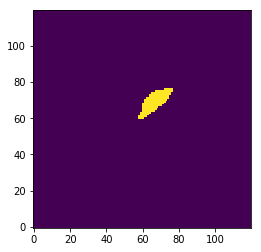

In [61]:
#Define mask to select only pixels to include in outflow calculations. I should probably draw a region
#manually around each outflow for these purposes, then I can further select pixels toward a contour in the
#moment0 maps at high velocities. https://astropy-regions.readthedocs.io/en/latest/masks.html
from regions import read_ds9
slab = sub12.spectral_slab(2*u.km/u.s, 4.7*u.km/u.s)
rms12 = rms(sub12, velocity_range=[[-2,0],[18,20]]*u.km/u.s)
print(rms12)
maskmom0_10sig = slab.moment0() > 10 * sigma_mom0(slab, channel_sigma=rms12)

#Using astropy.regions to read in a hand-drawn region from ds9.
reg_outflow = read_ds9("outflow_hops160.reg")[0]
reg_outflow_pix = reg_outflow.to_pixel(sub12.wcs)
mask_reg = reg_outflow_pix.to_mask().to_image(sub12.shape[1:]) == 1
mask_outflow = (mask_reg) & (maskmom0_10sig)
plt.imshow((mask_reg) & (maskmom0_10sig), origin='lower')

sub12_outflow = sub12.with_mask(mask_outflow)

In [56]:
#Calculate RMS in emission-free channels. Only consider pixels outside outflow mask.
rms12 = rms(sub12.with_mask(~mask_outflow), velocity_range=[[-2,0],[18,20]]*u.km/u.s)
rms13 = rms(sub13.with_mask(~mask_outflow), velocity_range=[[0,2], [16,18]]*u.km/u.s)
#Compute SNR mask at 3 sigma.
mask12_3sig = sub12 > 3*rms12
mask13_3sig = sub13 > 3*rms13
mask12_5sig = sub12 > 5*rms12
mask13_5sig = sub13 > 5*rms13
print(rms12, rms13)

1.0748504400253296 K 0.43354493379592896 K


30.71731820074934 K


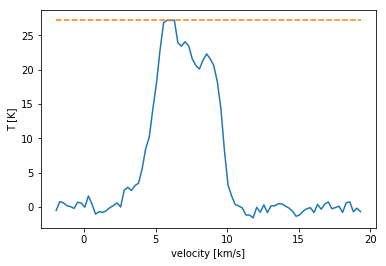

In [62]:
#Calculate Tex using the peak temperature of the average 12co spectrum.
Tex_peak = cube_Tex(sub12_outflow, thick=True, plot="tex.png", average=True, average_first=True)
print(Tex_peak)

Guessing these parameters:  {'amplitude': <Quantity 6.36847353 K>, 'mean': <Quantity 6.09070018 km / s>, 'stddev': <Quantity 6.16078414 km / s>}
Fitted C18O cloud components at 5.787399168123507 km / s


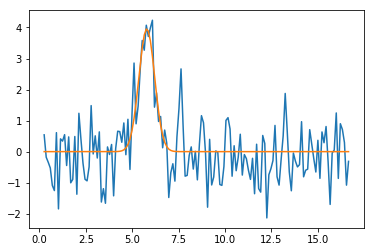

In [64]:
#Fit the C18O spectrum with 1 or more gaussians to get the mean velocity of the cloud, or cloud components
#along the line of sight.
c18o_radius = 15*u.arcsec
n = 1
sub18 = extract_subcube(c18, region_class=CircleSkyRegion,
                                    region_kwargs=dict(center=coord, radius=15*u.arcsec))

spec18_mean = extract_spectrum(sub18, spectral_unit=u.km/u.s)

spec18_gauss = fit_gaussian(spec18_mean.spectral_axis, spec18_mean, n_models=n, autoguess=True)
try:
    vsys = np.sort([g.mean.value for g in spec18_gauss])*spec18_mean.spectral_axis.unit
except TypeError:
    vsys = spec18_gauss.mean.value*spec18_mean.spectral_axis.unit
print("Fitted C18O cloud components at", vsys)
plt.plot(spec18_mean.spectral_axis, spec18_mean)
plt.plot(spec18_mean.spectral_axis, spec18_gauss(spec18_mean.spectral_axis))

5.787399168123507 km / s


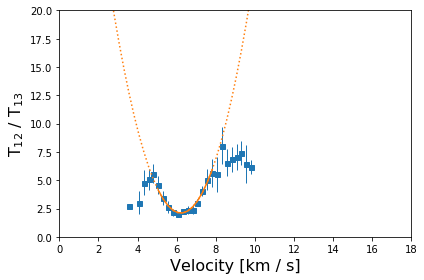

In [68]:
#Compute the velocity-dependent opacity correction. This could be fitting either a quadratic, or a 4-th order polynomial
#if there are two distinct cloud components.
fit_range = [5,8]*u.km/u.s
print(vsys)
sub12_correct, correctfactor = opacity_correct(sub12.with_mask(mask_outflow).with_mask(mask12_3sig), 
                                          sub13.with_mask(mask_outflow).with_mask(mask13_3sig),
                                          weighted_fit=True, fixed_fit=False,
                                          snr_cutoff=0, fit_func="parabola", vsys=vsys, fit_range=fit_range,    
                                          plot_ratio=True,
                                          errorbar_kwargs=dict(markersize=5, marker='s', ls='', lw=1, zorder=0),           
                                          plot_kwargs=dict(c='tab:orange'),
                                          return_factor=True)

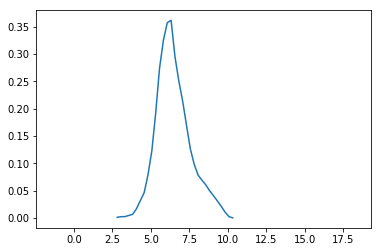

In [69]:
#Compute the mass spectrum in the outflow region
#and integrate starting 1 km/s away from the peak(s) to get the total mass of the outflow.
#the mass spectrum and masscube both have units of Msun / (km/s)
dmdv_correct, masscube_correct = dmdv(sub12_correct.with_mask(mask12_3sig), molecule='12co', Tex=Tex_peak,
                                     return_cube=True)
# print(dmdv_correct)
plt.plot(dmdv_correct.spectral_axis, dmdv_correct)

Guessing these parameters:  {'amplitude': <Quantity 0.36178534 s solMass / km>, 'mean': <Quantity 6.31334372 km / s>, 'stddev': <Quantity 7.75223246 km / s>}


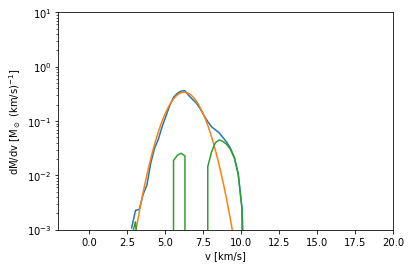

In [23]:
#Fit the mass spectrum with n gaussians and subtract off the cloud spectrum.
n = 1
# print(dmdv_correct.spectral_axis)
dmdv_outflow = ambient_correct(dmdv_correct, n_models=n, plot=True,
                               autoguess=True)
# print(dmdv_outflow)

In [71]:
#Integrate the outflow mass spectrum from +/- 1 km/s away from peak velocities.`
# dmdv_outflow.spectral_axis
dv = 1*u.km/u.s
vrange_amb = [4.7, vsys.value-dv.value]*u.km/u.s
mass_ambcorrect_blue = sum_dmdv(dmdv_outflow, vsys=vsys, vrange=vrange_amb, )
mass_blue = sum_dmdv(dmdv_correct, vrange=[-2,4.7]*u.km/u.s)
print(mass_ambcorrect_blue)
print(mass_blue)

0.0 solMass
0.02777358708467624 solMass


I should implement a check when subtracting the ambient cloud emission. I should only subtract up to the visually determined minimum outflow velocity. This will prevent cases such as this one, where the mass spectrum of the outflow is buried in the gaussian shape of the cloud mass spectrum, whereby we lose all the outflow mass when subtracting. I propose that we correct the ambient cloud in the following way. For all outflow velocities between 1 km/s and the minimum outflow velocity recorded in the outflow hunt csv file, I will subtract the ambient cloud fit from the total mass spectrum and add this corrected mass spectrum to the unsubtracted mass spectrum at higher velocities. Maybe I should report both of these values, corrected and uncorrected from ambient mass.

In [72]:
#Calculate the momentum and kinetic energy in the outflow. The only question here is what velocity
#do we use for each channel? It should be the outflow velocity, but what do we do in the case there is 
#more than one cloud velocity component? 
# v_out_blue = abs(min(vsys) - dmdv_outflow.spectral_axis)
# v_out_red = abs(max(vsys) - dmdv_outflow.spectral_axis)
# i_blue = dmdv_outflow.spectral_axis <= min(vsys)
# i_red = dmdv_outflow.spectral_axis >= max(vsys)
# i_between = (dmdv_outflow.spectral_axis >= min(vsys)) & (dmdv_outflow.spectral_axis <= max(vsys))
# v_out = np.copy(v_out_blue)
# v_out[dmdv_outflow.spectral_axis >= max(vsys)] = v_out_red[dmdv_outflow.spectral_axis >= max(vsys)]
# v_out[i_between] = 0
# print(v_out)
# print(v_out_blue)
M_blue = sum_dmdv(dmdv_correct, vsys=vsys, vrange=[-2,4.7]*u.km/u.s)
P_blue = momentum_dmdv(dmdv_correct, vsys=vsys, vrange=[-2,4.7]*u.km/u.s)
E_blue = energy_dmdv(dmdv_correct, vsys=vsys, vrange=[-2,4.7]*u.km/u.s)

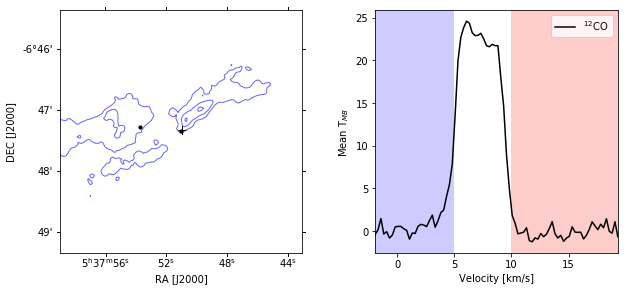

In [73]:
do_fit = 0
nsigma_vel = 3
blue_vel = 5*u.km/u.s
red_vel = 10.*u.km/u.s
fit_radius = 15*u.arcsec
width = height = 4*u.arcmin
start = 10.
stop = 50.
step = 5.
fig = plt.figure(figsize=(10,5))
plot_finder(c12, coord=coord,
            fit_cube=c12, fit_radius=fit_radius,
            nsigma_vel=nsigma_vel, blue_vel=blue_vel, red_vel=red_vel,
            fit_spectrum=do_fit, channel_sigma=sig12,
            region_width=width, region_height=height,
            blue_levels=np.arange(start, stop+step, step), red_levels=np.arange(start, stop+step, step),
            show_stamp=True, show_catalogs=True, show_spectrum=True, show_fit=do_fit,
            show_fitcircle=False, show_vrange=True, interactive=False, show_name=False,
            show_contour=1, show_redblue=0, show_outflows=False, redblue_mode='rgb',
            redblue_sigscale=1, rscale=[0.1,1], bscale=[0.1,0.9],
            imshow_kwargs={"cmap":"RdBu_r", "interpolation":"none", 'vmin':0, 'vmax':0.1},
            blue_contour_kwargs={'colors':'blue', 'linewidths':1, 'alpha':0.6, 'zorder':3},
            red_contour_kwargs={'colors':'red', 'linewidths':1, 'alpha':0.6, 'zorder':3},
            fig=fig, savefig=False, verbose=False, autoguess=True,
            spec_label=r'$^{12}$CO'
            )
plt.show()

2.9750943889825074 km / s


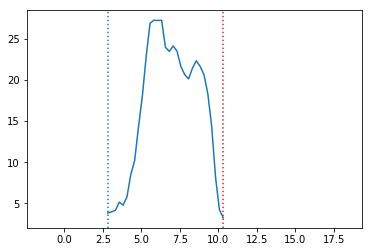

In [28]:
chans_detected = np.count_nonzero(~sub12.with_mask(mask_outflow).with_mask(mask12_3sig).apply_numpy_function(np.isnan), axis=(1,2)) >= 1
cube = sub12.with_mask(mask_outflow).with_mask(mask12_3sig)
vmax_blue, _ = vmax_cube(sub12.with_mask(mask_outflow).with_mask(mask12_3sig), vsys=vsys, min_pixels=1, plot=True)
print(vmax_blue)

### Calculate the R_max of the Outflow

0.09361346565646997 pc


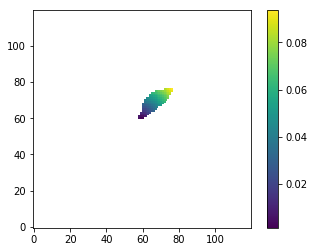

In [29]:
rmax_blue = rmax_cube(sub12.with_mask(mask_outflow), coord_zero=coord, dist=414*u.pc, plot=True)
print(rmax_blue)

### Calculate other derived properties.

In [75]:
t_dyn_blue = (rmax_blue / vmax_blue).to(u.yr)
Edot_blue = (E_blue / t_dyn_blue).to(u.erg/u.s)
Pdot_blue = (P_blue / t_dyn_blue).to(u.Msun * u.km / (u.s * u.yr))
Mdot_blue = (M_blue / t_dyn_blue).to(u.Msun/u.yr)
print(M_blue, P_blue, E_blue)
print("{:.2g}".format(t_dyn_blue))
print("{:.2g}, {:.2g}, {:.2g}".format(Edot_blue, Pdot_blue, Mdot_blue))

0.02777358708467624 solMass 0.04271060574664668 km solMass / s 0.03527422691554033 km2 solMass / s2
3.1e+04 yr
7.2e+29 erg / s, 1.4e-06 km solMass / (s yr), 9e-07 solMass / yr


Guessing position angle of -39.83466916887795 deg
Guessing these parameters:  {'amplitude': 37.0, 'mean': -8.592188375199413, 'stddev': 50.931681554369945}
[[ 6.73938194  0.87453331 -3.60512736]
 [ 0.87453331  4.37349382 -2.03691239]
 [-3.60512736 -2.03691239  5.4891962 ]]
-39.86746383431144 deg 55.810445577065124 deg


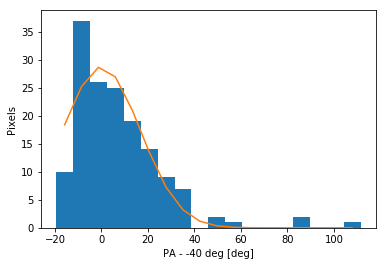

In [89]:
from physics import outflow_angles
pa, oa = outflow_angles(sub12.with_mask(mask_outflow), autoguess=True, plot=True)
print(pa, oa)